# Experiments with no sampling

In [1]:
!pip install grandiso

  Created wheel for grandiso: filename=grandiso-2.1.1-py3-none-any.whl size=15159 sha256=fa8c23b6f221298e9c842538e5fff1864f6bef1f1dd190248d52950a5834a8e8
  Stored in directory: /root/.cache/pip/wheels/c4/a2/f8/9ed72d95be070220db1e6e0f7771e1044dd00daeca9b06bcc5
Successfully built grandiso


In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 5.2 MB/s 
     |████████████████████████████████| 3.5 MB 5.4 MB/s 


In [3]:
# install ogb

!pip install ogb

     |████████████████████████████████| 78 kB 3.7 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=010815381ccd3ec561c93c10dc1d0593ede839685157720e327371f9f444f9e4
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


### imports

In [64]:
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform
from torch_geometric.datasets import TUDataset, ZINC
import torch_geometric.utils as uts
from torch_geometric.utils import remove_self_loops, to_undirected

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [5]:
# Graph libraries

import networkx as nx 
from grandiso import find_motifs

In [6]:
from ogb.graphproppred import PygGraphPropPredDataset

#### Load the drive for data files:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
# Mount the current directory
#%cd /content/drive/My\ Drive//CS159_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS159_project


## Graph processing code

### Enriched embedding classses

### Test graph class

In [7]:
####### testgraph class ##########
class testGraph: 
  '''
  A class object for a test graph with descriptive features
  '''
  def __init__(self, graph, graph_name = None, limit = None, format = 'networkx'):
    '''
     Parameters:
     graph: a graph in the format "format" (default is networkX)
     graph_name (String): the name of a graph 
     max_n (Int): a bound for the number of subgraphs taken
    '''
    self.name = graph_name
    self.__graph = graph
    self.bound = limit
    self.format = format
  def nx_graph(self):
    '''
     returns the graph in networkX format
    '''
    return self.__graph
  def pyg_graph(self):
    if self.format != 'networkx':
      raise Exception('Not implemented yet')
    return uts.convert.from_networkx(self.__graph)
  def draw(self):
    '''
     returns a drawing of the graph
    '''
    if self.format != 'networkx':
      return None
    return nx.draw(self.nx_graph())

###  Embedding classes

#### A general embedding class

In [59]:

####### generic Embedding class ##########
class Embedding():
  '''
  A class for for handeling the embeddings from subgraph isomorphism. 
  A specific class using aparticular graph homomorphism computation algorithm or library 
  inherits this class
  '''
  def __init__(self, graph, 
               testgraphs = None , 
               symmetry = True, 
               induced = False, 
               undirected = 'True',
               format = 'Torch'):
    self.__graph = graph
    self.graph = self.__graph
    if testgraphs == None: 
        self.testgraphs = {}
    else:
        self.testgraphs = testgraphs
    self.symmetry = symmetry
    self.induced = induced
    self.undirected = undirected
    self.format = format
  def nx_graph(self):
    '''
    returns the encoded graph in networkX format
    '''
    if self.format == 'networkx':
        return self.__graph
    if self.format == 'Torch':
        return uts.to_networkx(self.__graph, to_undirected = self.undirected)
    else:
      raise Exception('Not implemented yet')
  def pyg_graph(self):
    '''
    returns the encoded graph in torch_geometric.data format
    '''
    if self.format == 'Torch':
      return self.__graph
    else:
      raise Exception("Not implemented yet")
  def draw_graph(self):
    '''
     returns a drawing of the encoded graph
    '''
    return nx.draw(self.nx_graph())
  def add(self, test_graph):
    '''
     Adds a graph to the set of test graphs
     parameters:
     test_graph (testGraph) : graph to be added
    '''
    self.testgraphs[test_graph.name] = test_graph
  def add_from_iter(self, testgraphs):
    '''
     Adds graphs from an iterrable (e.g. list) to the set of test graphs
     parameters:
     testgraphs (testGraph) : iterator of graphs to be added
    '''
    dict_new_testgraphs = {F.name : F for F in testgraphs}
    self.testgraphs.update(dict_new_testgraphs)  
  def subIso(self, testgraph):
    raise NotImplementedError 
  def subIsodict(self):
    raise NotImplementedError      
  def num_encoder(self, format = 'Torch'):
    '''
    Returns the subgraph isomorphism vector in R^|testgraphs| given by (|subgraphIso(F,G)|)_F
    '''
    raise NotImplementedError
  def __pullback(self, testgraph, embedding,  format = 'Torch'):
    # returns the testgraph with features pulled back from the target graph along a map embedding
    '''
    input:
    testgraph (testGraph): a testgraph 
    embedding (gt.vertexpropertymap) :  an embedding of testgraph into the graph
    returns:
    subgraph (torch-geometric.data): testgraph as pyg data with features pulled along embedding
    '''
    raise NotImplementedError        
  


#### Embedding using grandIso  

In [61]:
class grandEmbedding(Embedding):
  '''
  A class for for handeling the embeddings from subgraph isomorphism. 
  '''
  def __init__(self, *kwargs):
    super().__init__(*kwargs)
  def subIso(self, testgraph):
    '''
    params:
    testgraph (testgraph): a testgraph to map from
    returns:
    returns a list of monomorphisms of the form
    "testgraph_id": "graph_id"
    '''
    graph = super(grandEmbedding, self).nx_graph()
    return iter(find_motifs(testgraph.nx_graph(), graph, limit = testgraph.bound))
  #def subIso(self, testgraph):
    # a public version of subIso, might be revoked in the future
    #return self.subIso(testgraph) 
  def num_encoder(self, format = 'Torch'):
    '''
    Returns the subgraph isomorphism vector in R^|testgraphs| given by (|subgraphIso(F,G)|)_F
    '''
    graph = super(grandEmbedding, self).nx_graph()
    num_auto = lambda x: find_motifs(x.nx_graph(), x.nx_graph(), limit = x.bound, count_only=True)
    num_all_subisos = lambda x: find_motifs(x.nx_graph(), graph, limit = x.bound, count_only=True)

    if format == 'Torch':
        return torch.tensor([num_all_subisos(test) for test in self.testgraphs.values()])
    elif format == 'numpy':
        return np.array([num_all_subisos(test) for test in self.testgraphs.values()])
    else:
      raise Exception("Format not supported")
  def ghc_agg(self, test):
    dict_indices = map(lambda x: x.values(), self.subIso(test))
    indices = map(lambda x: list(x), dict_indices)

    tensorlist = [torch.prod(self.graph.x[idx], dim = 0) for idx in indices]

    if len(tensorlist) == 0:
        num_node_features = self.graph.num_node_features
        return torch.zeros(num_node_features)  

    test_agg = torch.stack(tensorlist)
    
    return torch.sum(test_agg, dim = 0)
  def ghc_encoder(self, format = 'Torch'):
    '''
    An encoder in the style of the GHC paper
    '''
    if self.graph.num_node_features == 0:
      return self.num_encoder(format = format)
    embedding_tensor = torch.stack([self.ghc_agg(test) for test in self.testgraphs.values()])

    embedding_vector = embedding_tensor.flatten()
    if format == 'Torch':
        return embedding_vector
    elif format == 'numpy':
        return embedding_vector.detach().numpy()
    else:
      raise NotImplementedError("Format not supperted")    


In [62]:
G = uts.from_networkx(nx.cycle_graph(3))
emb = grandEmbedding(G)
f = testGraph(nx.cycle_graph(3))
emb.subIso(f)

## Test graphs

### Preparing the test graph set

In [63]:
MAX_n = 1000
# cycles:
test_cycles = [testGraph(nx.cycle_graph(n), graph_name= f'c_{n}', limit = MAX_n) for n in range(3,6)]
# trees:
make_tree = lambda tree, n, m : testGraph(tree, graph_name= f'tree of size {n} number {m}', limit = MAX_n)
make_non_is_trees = lambda n : [make_tree(tree, n, m) for m, tree in enumerate(list(nx.nonisomorphic_trees(n)))]
test_trees = list(itertools.chain.from_iterable([make_non_is_trees(n) for n in range(2,6)]))
# cliques
test_cliques = [testGraph(nx.complete_graph(n), graph_name= f'_{n}', limit = MAX_n) for n in range(4,6)]

F_testlist = list(itertools.chain(test_trees,test_cycles)) 


In [25]:
g = test_cliques[0].nx_graph()
sub = test_trees[1].nx_graph()


## Experiments: graph classification tasks

Set up environment 

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score

### First experiment: MUTAG:

Load the data

In [12]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


Process the data

In [13]:
# MUTAG with custom graphIso encoder

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [grandEmbedding(data) for data in dataset]
f = list(map(add_testgraphs, Encoded_Dataset))
#Encoded_Dataset[0]
X = np.array([data.num_encoder(format = 'numpy') for data in tqdm(Encoded_Dataset)])

#%timeit Encoded_Dataset[0].ghc_encoder()




100%|██████████| 188/188 [00:04<00:00, 43.49it/s]


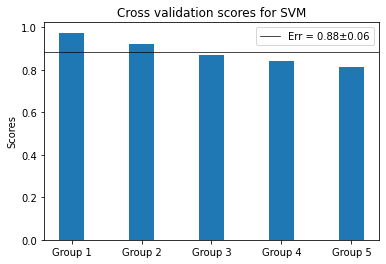

Error = 0.88±0.06


In [14]:
# Run classifier - MUTAG

clf = SVC(kernel='rbf')
cv = 5
width = 0.35

scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_weighted')
 

labels = [f'Group {n}' for n in range(1,cv+1)]
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(labels, scores, width)
ax.set_ylabel('Scores')
ax.set_title('Cross validation scores for SVM')
plt.axhline(y = scores.mean(), c = 'black', linewidth = 0.7, 
            label = f'Err = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')
ax.legend()

plt.show()
print(f'Error = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')




### Experiment: IMDB-BIN

In [87]:
dataset = TUDataset(root='data/IMDB-BINARY', name='IMDB-BINARY')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: IMDB-BINARY(1000):
Number of graphs: 1000
Number of features: 0
Number of classes: 2

Data(edge_index=[2, 146], y=[1], num_nodes=20)


Inspect:

In [88]:
# IMDB-Bin with custom graphIso encoder

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [grandEmbedding(data) for data in dataset]
f = list(map(add_testgraphs, Encoded_Dataset))
#Encoded_Dataset[0]
X = np.array([data.num_encoder(format = 'numpy') for data in tqdm(Encoded_Dataset)])

#%timeit Encoded_Dataset[0].ghc_encoder()

100%|██████████| 1000/1000 [09:51<00:00,  1.69it/s]


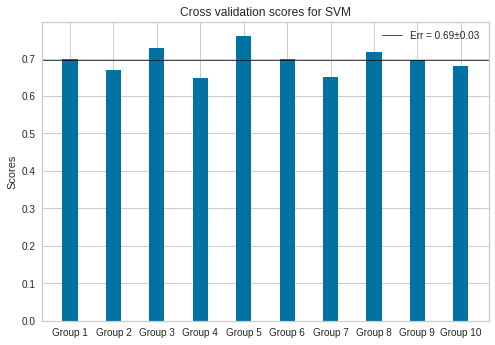

Error = 0.69±0.03


In [90]:
# Run classifier - IMDB-BIN

clf = SVC(kernel='rbf')
cv = 10
width = 0.35

scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_weighted')
 

labels = [f'Group {n}' for n in range(1,cv+1)]
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(labels, scores, width)
ax.set_ylabel('Scores')
ax.set_title('Cross validation scores for SVM')
plt.axhline(y = scores.mean(), c = 'black', linewidth = 0.7, 
            label = f'Err = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')
ax.legend()

plt.show()
print(f'Error = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')

### Experiment: "ogbg-molhiv" 

In [128]:
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
emb_dim = 10
atom_encoder = AtomEncoder(emb_dim)
bond_encoder = BondEncoder(emb_dim)

class atom_transform(BaseTransform):
  def __call__(self, data):
    newdata = data.clone()
    newdata.x = atom_encoder(data.x)
    return newdata

transform = atom_transform()

In [129]:
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/', transform = transform)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of features: 10
Number of classes: 2

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 10], y=[1, 1], num_nodes=19)


In [130]:
Encoded_Dataset = [grandEmbedding(data) for data in tqdm(dataset)]


  2%|▏         | 917/41127 [01:15<55:12, 12.14it/s]

100%|██████████| 41127/41127 [00:35<00:00, 1162.96it/s]


In [142]:
# ogbg-molhiv with custom graphIso encoder

# lables processing:
y = np.array([data.pyg_graph().y[0,0].detach().numpy() for data in Encoded_Dataset])

# vectors processing:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)
f = list(map(add_testgraphs, Encoded_Dataset))

#X = np.array([data.ghc_encoder(format = 'numpy')  for data in tqdm(Encoded_Dataset)])
%timeit Encoded_Dataset[0].ghc_encoder(format = 'numpy') 

10 loops, best of 5: 36.3 ms per loop


In [134]:
y.shape

(41127,)

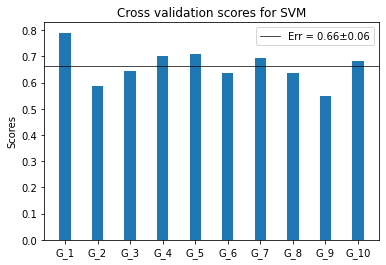

Error = 0.66±0.06


In [140]:
# Run classifier - ogbg-molhiv

clf = SVC(kernel='rbf', C  = 5)
cv = 10
width = 0.35

scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
 

labels = [f'G_{n}' for n in range(1,cv+1)]
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(labels, scores, width)
ax.set_ylabel('Scores')
ax.set_title('Cross validation scores for SVM')
plt.axhline(y = scores.mean(), c = 'black', linewidth = 0.7, 
            label = f'Err = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')
ax.legend()

plt.show()
print(f'Error = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')

### Experiment: Zinc

In [ ]:
dataset = ZINC(root='data/ZINC',subset=True)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

Extracting data/ZINC/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 13566.99it/s]


Dataset: ZINC(10000):
Number of graphs: 10000
Number of features: 1
Number of classes: 9994

Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])



Done!


Inspect:

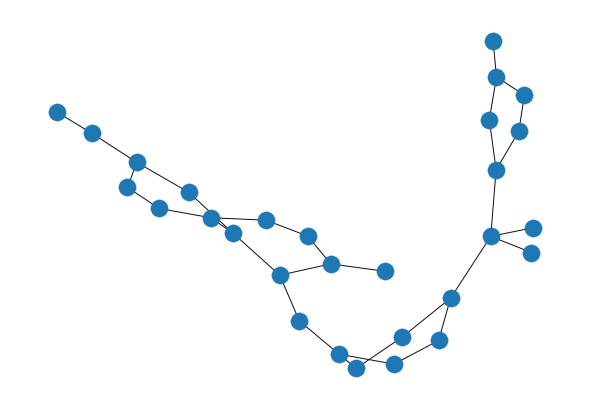

In [ ]:
G = uts.to_networkx(dataset[0],to_undirected = True)
nx.draw(G)


### Experiment: PROTEINS

Load the data:

In [143]:
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

Extracting data/TUDataset/PROTEINS/PROTEINS.zip
Processing...



Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 0
Number of classes: 2

Data(edge_index=[2, 162], x=[42, 0], y=[1])


Done!


inspect:

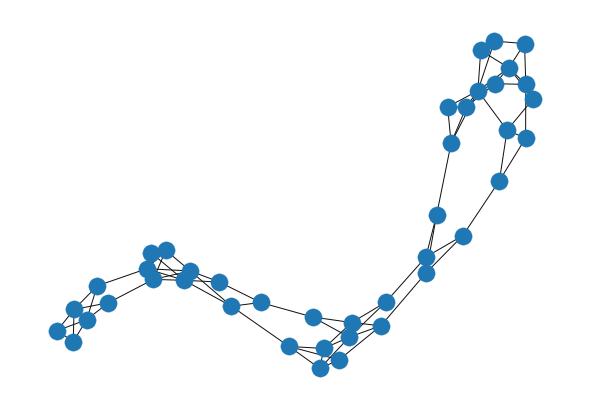

In [ ]:
G = uts.to_networkx(dataset[0],to_undirected = True)
nx.draw(G)

In [146]:
# PROTEINS with custom graphIso encoder

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [grandEmbedding(data) for data in dataset]
f = list(map(add_testgraphs, Encoded_Dataset))
#Encoded_Dataset[0]
X = np.array([data.num_encoder(format = 'numpy') for data in tqdm(Encoded_Dataset)])

#%timeit Encoded_Dataset[0].ghc_encoder(format = 'numpy')





  0%|          | 0/1113 [00:00<?, ?it/s]

  0%|          | 1/1113 [00:00<04:08,  4.48it/s]

  0%|          | 2/1113 [00:00<03:07,  5.93it/s]

  0%|          | 4/1113 [00:00<02:20,  7.89it/s]

  1%|          | 6/1113 [00:01<06:31,  2.83it/s]

  1%|          | 7/1113 [00:02<07:00,  2.63it/s]

  1%|          | 8/1113 [00:02<07:41,  2.39it/s]

  1%|          | 10/1113 [00:02<04:54,  3.74it/s]

  1%|          | 12/1113 [00:03<04:11,  4.38it/s]

  1%|          | 13/1113 [00:03<03:43,  4.91it/s]

  1%|▏         | 14/1113 [00:03<03:50,  4.77it/s]

  1%|▏         | 15/1113 [00:03<03:26,  5.31it/s]

  1%|▏         | 16/1113 [00:03<03:17,  5.55it/s]

  2%|▏         | 17/1113 [00:03<03:02,  6.02it/s]

  2%|▏         | 18/1113 [00:04<05:24,  3.38it/s]

  2%|▏         | 19/1113 [00:04<04:46,  3.81it/s]

  2%|▏         | 20/1113 [00:04<04:03,  4.48it/s]

  2%|▏         | 21/1113 [00:06<09:48,  1.86it/s]

  2%|▏         | 22/1113 [00:06<08:01,  2.26it/s]

  2%|▏         | 23/1113 [00:06<07:03,  2.57

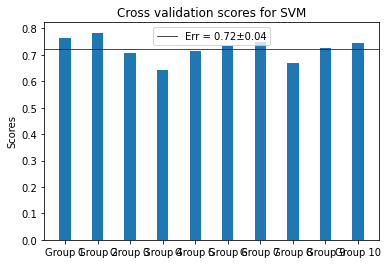

Validation error = 0.72±0.04


In [150]:
# Run classifier - PROTEINS

clf = SVC(kernel='rbf')
cv = 10
width = 0.35

scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_weighted')
 

labels = [f'Group {n}' for n in range(1,cv+1)]
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(labels, scores, width)
ax.set_ylabel('Scores')
ax.set_title('Cross validation scores for SVM')
plt.axhline(y = scores.mean(), c = 'black', linewidth = 0.7, 
            label = f'Err = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')
ax.legend()

plt.show()
print(f'Validation error = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')